## 데이터(3): 추천 시스템

#### 추천 시스템의 시초
- 인터넷이 등장하고 이메일이 활성화되기 시작하던 시기에 기존의 서비스 및 정보를 온라인으로 옮기는 작업 진행
    - 대표적으로 하루에도 수많은 양이 쏟아지는 뉴스 정보
    - 그러나 대부분의 사람들이 모든 뉴스를 궁금해하지 않는 것에 반해 지나치게 방대한 콘텐츠와 정보
    - 따라서 사람들이 원하는 정보만 골라서 제공해줄 수 있는 추천 시스템 필요

#### 고전적인 상품 추천 방식
- CB(Contents-Based)
    - 상품(영상, 제품, 식품 등등)의 상세 설명 기반
    - 키워드와 유사: 상품을 설명할 수 있는 대표 키워드
- KB(Knowledge-Based)
    - 개별 상품 및 상품 종류에 대한 지식 기반
    - 상품에 대한 지식을 기반으로 어떤 고객이 어떤 종류의 상품에 관심이 있을지 판단
- CB/KB의 장단점
    - 장점: 새로운 물건이나 고객에 바로바로 대응 가능
    - 단점: 물건의 종류 혹은 고객의 수가 많아지면 대응이 어려움
    - 현재는 상품 및 고객의 수가 무수히 많으므로 CB/KB 방식 적용 불가능

#### CF(Collaborative Filtering, 협업 필터링)
- 과거의 경향이 미래에도 계속 유지될 것이라고 가정
    - ex) 키보드를 구매한 고객에게 키보드를 구매한 다른 고객이 과거에 구매한 상품을 추천
    - 따라서 추천의 연결고리 패턴을 만드는 것이 중요
- User-Based: 특정 고객에게 유사한 선택을 했던 다른 고객의 선택을 추천
- Item-Based: 특정 상품을 선택한 고객에게 해당 상품을 선택한 다른 고객의 선택을 추천(ex: 아마존)
- 장점: 물건의 종류나 고객의 수가 많아져도 대응 가능(오히려 많아야 추천에 유리)
    - CB/KB의 단점을 해결
- 단점: 새로운 고객과 새로운 물건에 대응하기 어려움(cold-start issue)
    - 구매 이력이 없으므로 다른 고객, 물건과의 연결고리 x
    - 새로운 고객에 대응이 어려운 User-Based, 새로운 물건에 대응이 어려운 Item-Based

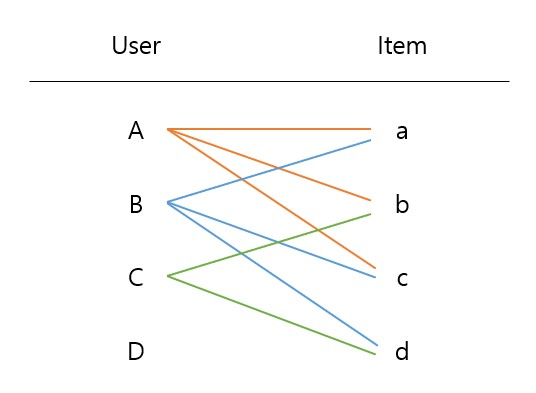

- User-Based(추천 대상: D)
    - D가 c를 선택했다면 c를 선택한 A, B가 동시에 선택한 a를 D에게 추천
- Item-Based(추천 대상: A)
    - A와 비슷한 구매 패턴을 가지는/겹치는 선택이 많은 B가 선택한 다른 상품인 d를 A에게 추천

#### 추천의 기준
- 추천 시스템 구현에서 가장 중요한 것은 상관관계
- 상품과 상품 간의 유사도, 고객과 고객 간의 유사도를 측정하여 추천을 진행

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### 데이터셋 출처
- https://grouplens.org/datasets/movielens/

In [2]:
path = 'C:/Users/Shiwon Kim/0_ML/test3'
movies = pd.read_csv(path + '/' + 'movies.csv')
ratings = pd.read_csv(path + '/' + 'ratings.csv')
print(movies.shape) # 영화를 장르별로 제공
print(ratings.shape) # 유저들이 영화에 매긴 평점

(9742, 3)
(100836, 4)


## Business Understanding
- cross-sell
    - 같이 사면 좋은 상품을 추천(끼워팔기)
    - 버거 단품 주문 고객에게 세트 메뉴를 추천
- up-sell
    - 같은 상품 중에서 마진율이 더 높은 상품을 추천
    - 일반 세트 메뉴 주문 고객에게 500원을 추가하여 라지 세트로 변경할 것을 추천
- down-sell
    - 구매 의사는 있지만 가격에 부담을 느끼는 고객에게 저렴한 대체재를 추천
    - 그랜저를 보는 고객에게 한 단계 아래 소나타를 추천

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

# 유저 한 명이 여러 개의 영화에 평점을 부여(일대일 x, 일대다 o)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# movieId 기준으로 데이터프레임 병합
combined = pd.merge(ratings, movies) # userId로 조회하기 위해 ratings, movies 순으로 병합
combined

# 유저와 영화 간의 연결관계를 보기 위해 A 유저가 B 아이템에 대해 C 점수를 주었다고 가정
# A: index, B: column, C: value -> 데이터프레임 생성

# 각 행은 한 명의 유저에 대한 선택 데이터, 각 컬럼은 하나의 영화에 대한 데이터,
# 행과 컬럼이 만나는 지점은 A가 B에 대해 C라는 점수를 주었다는 의미

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


#### 피벗테이블 생성
- 고객 및 상품 간의 유사도 산출에 사용
- pvt.corr()

In [6]:
combined.pivot_table(index='userId', columns='title', values='rating')

# 불필요한 데이터 처리 과정을 생략하기 위해 movieId 아닌 title 사용

# NaN은 유저가 해당 작품을 관람하지 않은 경우(유저와 영화 간의 연결고리 존재 x)
# 추천 시스템에서는 연결고리 패턴을 찾는 것이 중요 -> 평점이 NaN인 경우 rating을 0으로 처리 가능

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [7]:
pvt = combined.pivot_table(index='userId', columns='title', values='rating').fillna(0)
pvt

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


#### Item-Based
- 상품 간의 유사도를 계산

In [8]:
# 컬럼(movies) 간의 유사도를 산출: corr()
item_corr = pvt.corr()
item_corr

# 수치가 높을수록 연결고리가 크다는 것을 의미
# 상관계수(유사도) 측정 방법: 동일한 고객이 상품 A, B, C에 같은 +/- 경향의 점수 부여 -> 유사도 상승
# 더 나은 추천 시스템을 위해 상관계수를 구하는 방식에 대한 꾸준한 고민 필요

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,-0.001642,-0.002324,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,0.135943,-0.004325,...,-0.001642,0.339935,0.542247,0.706526,-0.001642,-0.007675,0.134327,0.325287,-0.008185,-0.001642
'Hellboy': The Seeds of Creation (2004),-0.001642,1.000000,0.706526,-0.001642,-0.002254,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Round Midnight (1986),-0.002324,0.706526,1.000000,-0.002324,-0.003191,-0.002324,0.170199,-0.002324,-0.014958,-0.006121,...,-0.002324,-0.006495,-0.003975,-0.003289,-0.002324,-0.010863,-0.010961,-0.005087,-0.011585,-0.002324
'Salem's Lot (2004),-0.001642,-0.001642,-0.002324,1.000000,0.857269,-0.001642,-0.006407,-0.001642,-0.010568,-0.004325,...,-0.001642,-0.004589,-0.002808,-0.002324,-0.001642,-0.007675,-0.007744,-0.003594,-0.008185,-0.001642
'Til There Was You (1997),-0.002254,-0.002254,-0.003191,0.857269,1.000000,-0.002254,-0.008797,-0.002254,-0.014510,-0.005938,...,-0.002254,-0.006301,-0.003856,-0.003191,-0.002254,-0.010538,-0.010632,-0.004935,-0.011238,-0.002254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),-0.007675,-0.007675,-0.010863,-0.007675,-0.010538,-0.007675,0.187953,0.212646,0.053614,0.115396,...,-0.007675,-0.021449,-0.013126,-0.010863,-0.007675,1.000000,0.163022,-0.016800,0.138611,-0.007675
xXx (2002),0.134327,-0.007744,-0.010961,-0.007744,-0.010632,-0.007744,0.062174,-0.007744,0.241092,-0.000060,...,0.063291,0.291410,0.163464,0.240394,-0.007744,0.163022,1.000000,0.259049,0.065673,-0.007744
xXx: State of the Union (2005),0.325287,-0.003594,-0.005087,-0.003594,-0.004935,-0.003594,-0.014025,-0.003594,0.139511,-0.009467,...,-0.003594,0.376455,0.172818,0.227658,-0.003594,-0.016800,0.259049,1.000000,-0.017917,-0.003594


In [9]:
# 매트릭스 시리즈에 관심이 있다고 가정
target = 'Matrix'

# 제목에 'Matrix'가 포함된 영화를 출력
for title in item_corr.columns:
    if target in title:
        print(title)

Matrix Reloaded, The (2003)
Matrix Revolutions, The (2003)
Matrix, The (1999)


In [10]:
interested = 'Matrix, The (1999)'

# 매트릭스 영화를 좋아한 사람의 다른 영화에 대한 선호도를 높은 순으로 조회
item_corr.sort_values(by=interested, ascending=False)[interested].head()

# item-based:
# 영화에 대한 정보(배우, 장르, 감독)가 없음에도 사람들이 선호할 만한 유사한 영화를 확인 가능
# 아래 상관계수 상위 영화들을 검색해보면 매트릭스 시리즈와 장르가 유사

title
Matrix, The (1999)                                       1.000000
Fight Club (1999)                                        0.538214
Star Wars: Episode V - The Empire Strikes Back (1980)    0.522634
Saving Private Ryan (1998)                               0.508636
Sixth Sense, The (1999)                                  0.476540
Name: Matrix, The (1999), dtype: float64

#### User-Based
- 유저 간의 유사도를 계산
- 특정 고객이 관심 있어할 만한 상품을 추천하는 것이 목적
 - 해당 고객과 유사한 성향의 고객이 구매한 상품 중 해당 고객이 구매하지 않은 상품을 추천

In [11]:
user_corr = pvt.T.corr()
user_corr

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.019396,0.053052,0.176911,0.120862,0.104406,0.143785,0.128542,0.055263,-0.000307,...,0.066248,0.149934,0.186959,0.056523,0.134402,0.121958,0.254192,0.262225,0.085430,0.098693
2,0.019396,1.000000,-0.002595,-0.003808,0.013181,0.016252,0.021564,0.023748,-0.003450,0.061877,...,0.198547,0.010885,-0.004038,-0.005348,-0.007923,0.011290,0.005809,0.032723,0.024371,0.089321
3,0.053052,-0.002595,1.000000,-0.004559,0.001886,-0.004581,-0.005637,0.001701,-0.003112,-0.005504,...,0.000148,-0.000588,0.011203,-0.004824,0.003674,-0.003255,0.012881,0.008089,-0.002964,0.015953
4,0.176911,-0.003808,-0.004559,1.000000,0.121014,0.065707,0.100595,0.054231,0.002412,0.015607,...,0.072841,0.114280,0.281852,0.039692,0.065483,0.164812,0.115109,0.116843,0.023926,0.062498
5,0.120862,0.013181,0.001886,0.121014,1.000000,0.294134,0.101721,0.426575,-0.004187,0.023468,...,0.061908,0.414929,0.095386,0.254115,0.141073,0.090149,0.145760,0.122600,0.258288,0.040361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.121958,0.011290,-0.003255,0.164812,0.090149,0.047476,0.172484,0.081904,0.057979,0.054858,...,0.153879,0.084190,0.224593,0.035234,0.106729,1.000000,0.115978,0.188312,0.052375,0.093788
607,0.254192,0.005809,0.012881,0.115109,0.145760,0.142158,0.173287,0.178130,0.003252,-0.004817,...,0.080027,0.187581,0.173008,0.126261,0.101129,0.115978,1.000000,0.258232,0.142529,0.098496
608,0.262225,0.032723,0.008089,0.116843,0.122600,0.137932,0.305429,0.175906,0.086221,0.048357,...,0.136304,0.174056,0.164440,0.133722,0.144878,0.188312,0.258232,1.000000,0.109556,0.248902


In [12]:
# 특정 고객과 높은 유사도를 가지는 고객을 조회
interested = 379
user_corr.sort_values(by=interested, ascending=False)[interested].head()

##### 주의 사항 #####
# 상관계수가 지나치게 클 경우 이미 구매한 상품(교집합)일 가능성이 높아 오히려 추천이 어려움
# 이런 점을 고려하여 유사도가 너무 높은 126 말고 470 고객으로 진행
# 470 고객은 봤는데 379 고객은 보지 않은 영화를 추천 -> 차집합

userId
379    1.000000
126    0.812737
470    0.700414
347    0.688932
94     0.688177
Name: 379, dtype: float64

#### 방법 1)

In [13]:
user_1, user_2 = 379, 470
u1 = set(combined.loc[combined['userId'] == user_1]['title'])
u2 = set(combined.loc[combined['userId'] == user_2]['title'])

In [14]:
# 차집합 출력
diff = u2.difference(u1)

# 이들 중에서 평점이 높은 영화를 추천

In [15]:
u2_all = combined.loc[combined['userId'] == user_2]
filtered = u2_all.loc[combined['title'].isin(diff)]
filtered.sort_values(by='rating', ascending=False).head()['title']

162                        Toy Story (1995)
19602    Four Weddings and a Funeral (1994)
32487             Executive Decision (1996)
30909         Star Trek: Generations (1994)
26669        Remains of the Day, The (1993)
Name: title, dtype: object

#### 방법 2)

In [16]:
list_470 = pvt.T.loc[(pvt.T[470] >= 4) & (pvt.T[379] == 0), [379, 470]]
list_470

userId,379,470
title,,
Addams Family Values (1993),0.0,4.0
Dead Man Walking (1995),0.0,4.0
Executive Decision (1996),0.0,4.0
Four Weddings and a Funeral (1994),0.0,4.0
Legends of the Fall (1994),0.0,4.0
Nixon (1995),0.0,4.0
Quiz Show (1994),0.0,4.0
"Remains of the Day, The (1993)",0.0,4.0
Star Trek: Generations (1994),0.0,4.0


In [17]:
list_470.loc[pvt.T[379] == 0].index

Index(['Addams Family Values (1993)', 'Dead Man Walking (1995)',
       'Executive Decision (1996)', 'Four Weddings and a Funeral (1994)',
       'Legends of the Fall (1994)', 'Nixon (1995)', 'Quiz Show (1994)',
       'Remains of the Day, The (1993)', 'Star Trek: Generations (1994)',
       'Toy Story (1995)', 'Twister (1996)',
       'Willy Wonka & the Chocolate Factory (1971)'],
      dtype='object', name='title')

In [18]:
# 이번 데이터의 경우 용량이 작아 분석이 용이했지만,
# CF의 목적상 대용량 데이터 필요 -> 다른 방식의 접근